In [23]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from astropy.io import fits
from astropy import units as u
from sklearn.metrics import r2_score
from astropy import wcs, coordinates
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split


from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback

def make_gen(x):
    def gen():
      i = 0
      while(i<len(x)):
        yield next(x)
        i +=1
    return gen

def add_noise(img,sigma=0.01):
    '''Add random noise to an image'''
    deviation = sigma*np.random.uniform(0,1)
    noise = np.random.normal(0, sigma, img.shape)
    img += noise
    np.clip(img, 0., 1.)
    return img


### Loading the data, __sky__ is 21cm cube and __cont__ is continuum image and catalogue.

In [3]:
data_path = '/home/vafaeisa/scratch/ska/'

In [4]:
sky = fits.open(data_path+'development/sky_dev_v2.fits')
cont = fits.open(data_path+'development/cont_dev.fits')
sources = pd.read_csv(data_path+'development/sky_dev_truthcat_v2.txt',delimiter=' ')
sources = sources.sort_values('line_flux_integral',ascending=0).reset_index()

psky = sky[0].data
csky = cont[0].data

# smoothed_sky = gaussian_filter(sky[0].data,sigma=(3,3,5))

In [5]:
header = sky[0].header

dfreq = header['CDELT3']
freq0 = header['CRVAL3']

# frequency list in the HI cube
nf,nx,ny = sky[0].data.shape
freqs = np.arange(freq0,freq0+nf*dfreq,dfreq)
fqmhz = freqs/1e6

coord_sys = wcs.WCS(header)
ra, dec = sources['ra'],sources['dec']
num_sources = len(ra)
radec_coords = coordinates.SkyCoord(ra=ra, dec=dec, unit='deg', frame='fk5')
coords_ar = np.vstack([radec_coords.ra*u.deg, radec_coords.dec*u.deg,
                         np.zeros(num_sources)]).T
xy_coords = coord_sys.wcs_world2pix(coords_ar, 0)
x_coords, y_coords = xy_coords[:,0], xy_coords[:,1]
f_coordsf = sources['central_freq']

In [6]:
ds = 10
dff = 50
patches = []
chars = []
for ii in range(sources.shape[0]):
    source = sources.loc[ii,:]
    ra_s = source['ra']
    dec_s = source['dec']
    freq_s = source['central_freq']
    ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
    ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]
    patch = psky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
    if patch.shape!=(2*dff+1,2*ds+1,2*ds+1):
        continue
    
    patches.append(patch.T)
    chars.append(sources.loc[ii,['hi_size','line_flux_integral','pa','i','w20']].values)

patches = np.array(patches)
chars = np.array(chars)
ndata,nd1,nd2,nd3 = patches.shape
n_classes = chars.shape[1]
patches.shape,chars.shape

((2580, 21, 21, 101), (2580, 5))

### Target character visualization

''

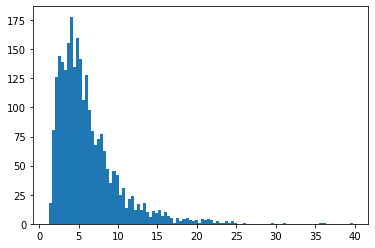

In [14]:
plt.hist(chars[:,0],100)
# plt.xscale('log')
;

In [8]:
data_gen_args = dict(rotation_range=0,
                     width_shift_range=0.01,
                     height_shift_range=0.01,
                     zoom_range=0.01,
                     horizontal_flip=True,
                     vertical_flip=True,
#                      preprocessing_function=add_noise,
                     fill_mode="nearest")

aug = ImageDataGenerator(**data_gen_args)
# flow = aug.flow(X_train,y_train,batch_size=32,seed=0)
# flow_gen = make_gen(flow)
# dataset = tf.data.Dataset.from_generator(flow_gen,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))


## Classification
We can reduce the problem to a classification problem to see how much the information is retrievable.

In [9]:
nclass = 2
cls_ch = np.zeros((chars.shape[0],5,nclass))
pbins = np.linspace(0,100,nclass+1)
for i in range(5):
    xx = chars[:,i]
    bins = []
    for j in range(nclass+1):
        bins.append(np.percentile(xx,pbins[j]))
    
    for j in range(nclass):
        filt = (bins[j]<xx) & (xx<bins[j+1])
        cls_ch[filt,i,j] = 1


#### a schematic vew of the lables

[]

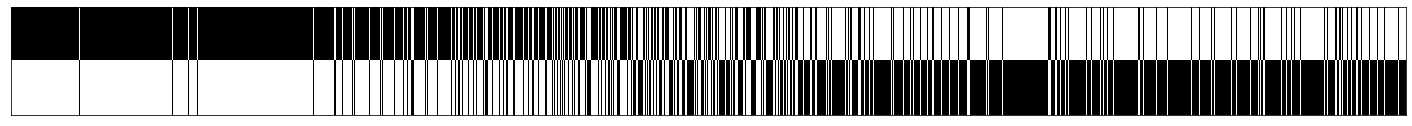

In [12]:
fig,ax = plt.subplots(figsize=(25,2))
ax.imshow(cls_ch[:,0,:].T,cmap='gray',aspect='auto',interpolation='none')
ax.set_xticks([])
ax.set_yticks([])

Now we have all 5 target values converted into 2 classes

In [16]:
cls_ch.shape

(2580, 5, 2)

### 3D architecture definition

In [17]:
def HighRes3DNetClassifier(input_shape, n_classes=1, activation="relu", l1=1e-10, dropout_rate=0, name="highresnet"):
    """Instantiate HighResNet model."""

    conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
    n_repeat = 3
    n_base_filters = 4

    inputs = layers.Input(shape=input_shape)
    x = tf.expand_dims(inputs,-1)
    x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

    for ii in range(n_repeat):
        skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.Add()([x, skip])

        x = layers.MaxPooling3D((2, 2, 4))(x)

#     x = ZeroPadding3DChannels(n_base_filters//2)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)


    sh = x.shape[1:]
#     print(sh)
    x = layers.Flatten()(x)

#     x = layers.Dense(np.prod(sh)//2, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_classes, activation="linear")(x)

#     x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

#     final_activation = "sigmoid" if n_classes == 1 else "softmax"
#     final_activation = "relu"
#     x = layers.Activation(final_activation)(x)
#     x = tf.squeeze(x,-1)
    
#     x = layers.Flatten()(x)

#     x = layers.Dense(n_latent, activation="relu")(x)
#     x = layers.Dropout(0.6)(x)
#     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


    # QUESTION: where should dropout go?
    model = keras.Model(inputs=inputs, outputs=x, name=name) 

    model.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return model

You can select the target by __ii__

    0) Integrated line flux (Jy Hz)

    1) HI size (arcsec)

    2) Line width (km/s)

    3) Position angle (degrees)

    4) Inclination angle (degrees)
    
Warning: watch for augmentations!

In [20]:
batch_size=32

ii = 4
X_train, X_test, y_train, y_test = train_test_split(patches,cls_ch[:,ii,:], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

flow = aug.flow(X_train,y_train,batch_size=32,seed=0)

(2064, 21, 21, 101) (516, 21, 21, 101) (2064, 2) (516, 2)


/home/vafaeisa/miniconda3/envs/gpu1/lib/python3.9/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2064, 21, 21, 101) (101 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


In [21]:
model = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=nclass)
model.summary(line_length=120,positions=[.33, .55, .67, 1.])

Model: "highresnet"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   [(None, 21, 21, 101)]      0                                                     
________________________________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)            (None, 21, 21, 101, 1)     0             input_1[0][0]                           
________________________________________________________________________________________________________________________
conv3d (Conv3D)                        (None, 21, 21, 101, 4)     112           tf.expand_dims[0][0]                    
________________________________________________________________________________________________________________________
batch_normal

In [26]:
history = model.fit(flow,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=10,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

OR we could try it as regression problem to predict all 5 values. This approach does not see to work easily

# Regression

In [62]:
# mins = 
means = np.mean(chars,axis=0,keepdims=1)
stds = np.std(chars,axis=0,keepdims=1)

chars_norm = chars-means
chars_norm = chars_norm/stds


mins = np.min(chars,axis=0,keepdims=1)
maxs = np.max(chars,axis=0,keepdims=1)

chars_norm = chars-mins
chars_norm = chars_norm/(maxs-mins)
# chars.shape
chars_norm = chars_norm.astype(np.float32)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches,chars_norm, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

flow = aug.flow(X_train,y_train,batch_size=32,seed=0)

/home/vafaeisa/miniconda3/envs/gpu1/lib/python3.9/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2064, 21, 21, 101) (101 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


(32, 21, 21, 101) (32, 5)


(-0.5, 20.5, 20.5, -0.5)

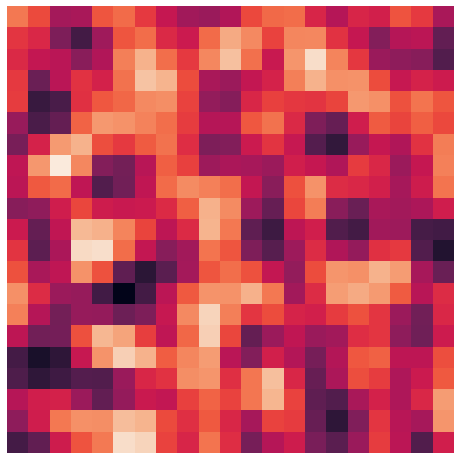

In [64]:
# xample,yample = dataset.batch(10)

for e1,e2 in flow:
    print(e1.shape,e2.shape)
    break

fig,ax = plt.subplots(1,1,figsize=(8,3*nd3))

i = np.random.randint(e1.shape[0])
ax.imshow(e1[i,:,:,:].mean(axis=-1))
ax.axis('off')
ax.axis('off')

In [108]:
# data_gen_args = dict(rotation_range=10,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      zoom_range=0.05,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      preprocessing_function=add_noise,
#                      fill_mode="nearest")

# aug1 = ImageDataGenerator(**data_gen_args)
# aug2 = ImageDataGenerator(**data_gen_args)

# nac = nac_data_set[dname]
# mac = mac_data_set[dname]

# nac_flow = aug1.flow(nac,batch_size=BS,seed=seed)
# mac_flow = aug2.flow(mac,batch_size=BS,seed=seed)
# gen_nac = make_gen(nac_flow)
# gen_mac = make_gen(mac_flow)
# dataset1 = tf.data.Dataset.from_generator(gen_nac,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))
# dataset2 = tf.data.Dataset.from_generator(gen_mac,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))
# dataset3 = tf.data.Dataset.zip((dataset1, dataset2))#.batch(10)

# federated_train_data.append(dataset3)

In [109]:
# class ZeroPadding3DChannels(layers.Layer):
#     """Pad the last dimension of a 5D tensor symmetrically with zeros.
#     This is meant for 3D convolutions, where tensors are 5D.
#     """

#     def __init__(self, padding, **kwds):
#         self.padding = padding
#         # batch, x, y, z, channels
#         self._paddings = [[0, 0], [0, 0], [0, 0], [0, 0], [self.padding, self.padding]]
#         super(ZeroPadding3DChannels, self).__init__(**kwds)

#     def call(self, x):
#         return tf.pad(x, paddings=self._paddings, mode='CONSTANT', constant_values=0)
    
#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'padding': self.padding 
#         })
#         return config

# def HighRes3DNet(input_shape, n_classes=1, activation="relu", dropout_rate=0, name="highresnet"):
#     """Instantiate HighResNet model."""

#     conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
#     n_repeat = 1
#     n_base_filters = 4

#     inputs = layers.Input(shape=input_shape)
#     x = tf.expand_dims(inputs,-1)
#     x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters//2)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

# #     final_activation = "sigmoid" if n_classes == 1 else "softmax"
#     final_activation = "relu"
#     x = layers.Activation(final_activation)(x)
#     x = tf.squeeze(x,-1)
    
# #     x = layers.Flatten()(x)

# #     x = layers.Dense(n_latent, activation="relu")(x)
# #     x = layers.Dropout(0.6)(x)
# #     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


#     # QUESTION: where should dropout go?

#     return tf.keras.Model(inputs=inputs, outputs=x, name=name) 

# model0 = HighRes3DNet(input_shape=(nd1,nd2,nd3))
# model0.summary(line_length=120,positions=[.33, .55, .67, 1.])

In [110]:
class ZeroPadding3DChannels(layers.Layer):
    """Pad the last dimension of a 5D tensor symmetrically with zeros.
    This is meant for 3D convolutions, where tensors are 5D.
    """

    def __init__(self, padding, **kwds):
        self.padding = padding
        # batch, x, y, z, channels
        self._paddings = [[0, 0], [0, 0], [0, 0], [0, 0], [self.padding, self.padding]]
        super(ZeroPadding3DChannels, self).__init__(**kwds)

    def call(self, x):
        return tf.pad(x, paddings=self._paddings, mode='CONSTANT', constant_values=0)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'padding': self.padding 
        })
        return config

def HighRes3DNetRegressor(input_shape, n_classes=1, activation="relu", l1=1e-10, dropout_rate=0, name="highresnet"):
    """Instantiate HighResNet model."""

    conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
    n_repeat = 3
    n_base_filters = 4

    inputs = layers.Input(shape=input_shape)
    x = tf.expand_dims(inputs,-1)
    x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

    for ii in range(n_repeat):
        skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.Add()([x, skip])

        x = layers.MaxPooling3D((2, 2, 4))(x)

#     x = ZeroPadding3DChannels(n_base_filters//2)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)


    sh = x.shape[1:]
#     print(sh)
    x = layers.Flatten()(x)

    x = layers.Dense(np.prod(sh)//2, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(n_classes, activation="linear")(x)

#     x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

#     final_activation = "sigmoid" if n_classes == 1 else "softmax"
#     final_activation = "relu"
#     x = layers.Activation(final_activation)(x)
#     x = tf.squeeze(x,-1)
    
#     x = layers.Flatten()(x)

#     x = layers.Dense(n_latent, activation="relu")(x)
#     x = layers.Dropout(0.6)(x)
#     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


    # QUESTION: where should dropout go?
    model = keras.Model(inputs=inputs, outputs=x, name=name) 

    model.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.MeanSquaredError(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return model

# model0 = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=n_classes)
# model0.summary(line_length=120,positions=[.33, .55, .67, 1.])

In [111]:
# X_train, X_test, y_train, y_test = train_test_split(patches,chars_norm, test_size=0.2, random_state=42)

# plt.hist(np.log(y_train[:,1]+1e-3))

In [112]:
models = []
fluxmins = []
# topw = np.array([500,700,1000,1500,2000,y_train.shape[0]])
topw = np.array([y_train.shape[0]])

for i in range(len(topw)):
#     filt = trsh<np.log(y_train[:,1]+1e-5)
#     flux = y_train[:,1]
#     inds = np.argsort(flux)[::-1]
#     inds = inds[:topw[i]]
#     fluxmin = np.min(y_train[inds,1])
#     print(i,fluxmin)
#     fluxmins.append(fluxmin)
    data_gen_args = dict(rotation_range=10,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.05,
                         horizontal_flip=True,
                         vertical_flip=True,
                         preprocessing_function=add_noise,
                         fill_mode="nearest")

    aug = ImageDataGenerator(**data_gen_args)
    print(X_train[inds].shape,y_train[inds].shape)
    flow = aug.flow(X_train[inds],y_train[inds],batch_size=32,seed=0)
    batch_size = 32
    
    model = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=n_classes)
    history = model.fit(flow,
                        steps_per_epoch=X_train[inds].shape[0] // batch_size,
                        epochs=150,
                        verbose=0)
    
    models.append(model)

(773, 21, 21, 121) (773, 1)


In [113]:
# # for i,fluxmin in enumerate(fluxmins):
# #     filt1 = fluxmin<y_train[:,1]
# #     filt = fluxmin<y_test[:,1]
# #     print(filt1.sum(),filt.sum())



# r2s = []

# for i,fluxmin in enumerate(fluxmins):
# #     filt = fluxmin<y_test[:,1]
#     data_gen_args = dict(rotation_range=10,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.05,
#                          horizontal_flip=True,
#                          vertical_flip=True,
#                          preprocessing_function=add_noise,
#                          fill_mode="nearest")

# #     aug = ImageDataGenerator(**data_gen_args)
# #     flow = aug.flow(X_test[filt],y_test[filt],batch_size=32,seed=0)
# #     batch_size = 32

#     model = models[i]
    
#     y_pred = model.predict(X_test)
#     rp = []
#     for j in range(n_classes): 
#         rp.append(r2_score(y_test[:,j],y_pred[:,j]))
#     r2s.append(rp)
# r2s = np.array(r2s)
# print(r2s)

In [114]:
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     preprocessing_function=add_noise,
                     fill_mode="nearest")

#     aug = ImageDataGenerator(**data_gen_args)
#     flow = aug.flow(X_test[filt],y_test[filt],batch_size=32,seed=0)
#     batch_size = 32

model = models[0]

y_pred = model.predict(X_test)
rp = []
for j in range(n_classes): 
    print(r2_score(y_test[:,j],y_pred[:,j]))

-0.012581847198845253


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

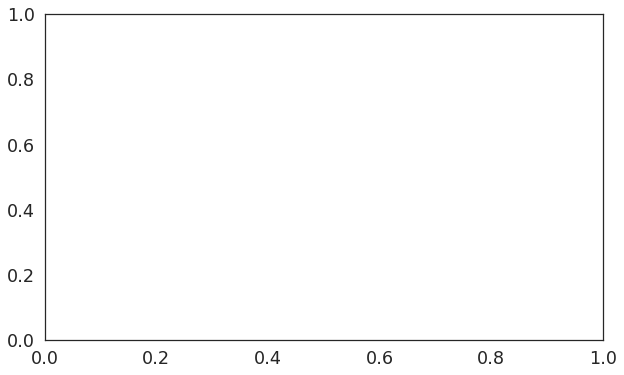

In [63]:
lbls = ['hi_size','line_flux_integral','pa','i','w20']

fig,ax = plt.subplots(1,1,figsize=(10,6))

for i in range(n_classes):
    ax.plot(fluxmins,r2s[:,i],label=lbls[i])
    
ax.set_ylim(-2,1)
ax.legend(loc=(1,0.6))

(array([ 9., 27., 56., 62., 31.,  7.,  0.,  0.,  1.,  1.]),
 array([0.62516844, 0.6251741 , 0.62517977, 0.62518543, 0.6251911 ,
        0.6251967 , 0.62520236, 0.625208  , 0.6252137 , 0.62521935,
        0.625225  ], dtype=float32),
 <BarContainer object of 10 artists>)

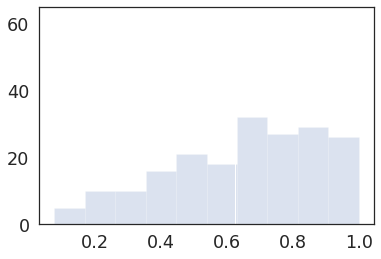

In [39]:
j = 3

plt.hist(y_test[:,j],color='b',alpha=0.2)
plt.hist(y_pred[:,j],color='r')

In [40]:
# y_pred[:,j]

In [41]:
1

1